In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
import scipy.fft
import pandas as pd
import os
import scipy.interpolate
import matplotlib.ticker as ticker
import matplotlib.patches as patches

In [24]:
settings = {'axes.labelsize': 32,
 'xtick.major.size': 10,
 'xtick.major.width': 1.5,
 'xtick.labelsize': 24,
 'ytick.major.size': 10,
 'ytick.major.width': 1.5,
 'ytick.labelsize': 24,
 'legend.fontsize': 18,
 'lines.linewidth': 4,
 'lines.markersize': 10,
 'font.size': 30}

# VCO Characterization

In [135]:
Vs_vco = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5]) # V 
freqs = np.array([22.8, 22.4, 21.9, 21.4, 20.9, 20.5, 19.3, 18, 15.5])  # kHz

k = 30.64464 kHz/V
omega0 = 143.72222 kHz
f0 = 22.87410 kHz
Slope uncertainty = 0.25220821124223025 kHz/V
Y-int uncertainty = 0.17559 kHz/V


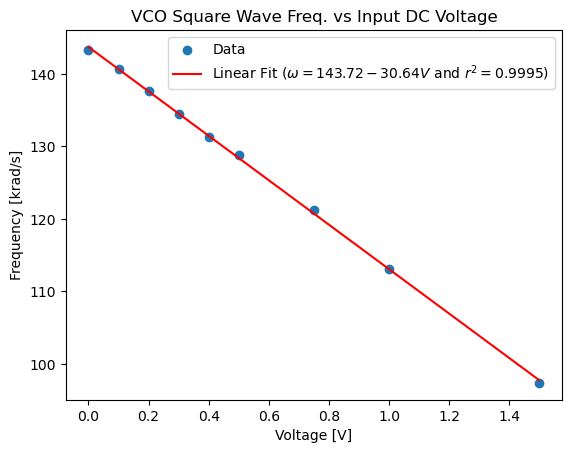

In [148]:
result_vco = scipy.stats.linregress(Vs_vco, 2 * np.pi * freqs)
negk = result_vco.slope
omega0 = result_vco.intercept
r = result_vco.rvalue
slope_err = result_vco.stderr
yint_err = result_vco.intercept_stderr

k = -negk
plt.scatter(Vs_vco, 2 * np.pi * freqs, label='Data')
plt.plot(X:=np.array([min(Vs_vco), max(Vs_vco)]), omega0 + negk * X, 
         label=f'Linear Fit ($\omega = {omega0:.2f} - {k:.2f}V$ and $r^2 = {r**2:.4f})$', 
         c='red')
plt.xlabel('Voltage [V]')
plt.ylabel('Frequency [krad/s]')
plt.title('VCO Square Wave Freq. vs Input DC Voltage')
plt.legend();
print(f'k = {k:.5f} kHz/V')
print(f'omega0 = {omega0:.5f} kHz')
print(f'f0 = {omega0 / (2 * np.pi):.5f} kHz')
print(f'Slope uncertainty = {slope_err} kHz/V')
print(f'Y-int uncertainty = {yint_err:.5f} kHz/V')

# Integrator Variable Resistor Characterization

In [8]:
knob = [0, 1, 3, 5, 7, 8, 9]
Vs_res = [10.03, 10.94, 12.90, 14.93, 16.95, 18.02, 19.01] #kOhm

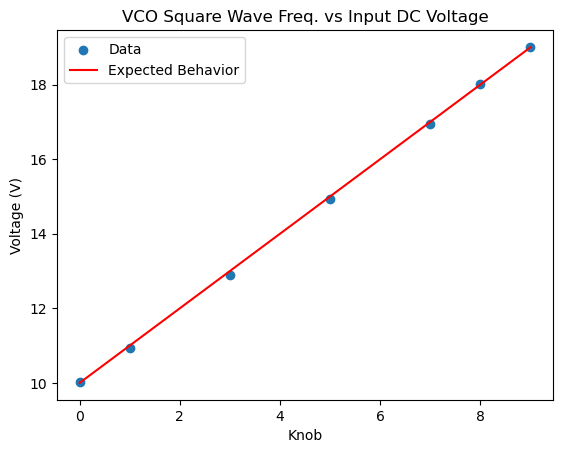

In [12]:
plt.scatter(knob, Vs_res, label='Data')
plt.plot([0, 9], [10, 19], c='red', label='Expected Behavior')
plt.xlabel('Knob')
plt.ylabel('Voltage (V)')
plt.title('VCO Square Wave Freq. vs Input DC Voltage')
plt.legend();

# Bifurcation Plot

In [14]:
def read_osc_csv(file):
    df = pd.read_csv(file, names=['t', 'x', 'y'])
    return df.apply(pd.to_numeric, errors='coerce').dropna()

In [16]:
def real_modulo(x, y):
    return x - y * np.floor(x/y)

In [19]:
run1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.66, 0.67, 0.67025, 0.6705, 0.67075, 0.671, 0.672, 0.7, 0.8, 0.9]
run2 = [0.92, 0.93, 0.94, 0.945, 0.95, 0.951, 0.952, 0.953, 0.954, 0.955, 0.96, 0.97, 0.98, 0.99, 0.995, 1, 1.005, 
        1.01, 1.0125, 1.015, 1.0175, 1.02, 1.0225, 1.025, 1.0275, 1.03, 1.0325, 1.035, 1.0375, 1.04]
run3 = [1.05, 1.06, 1.07, 1.08, 1.09, 1.10, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.1805, 1.181, 1.1815, 1.182, 1.185, 
        1.187, 1.19, 1.192, 1.195, 1.198, 1.199, 1.2, 1.225, 1.25, 1.3, 1.325] # accidentally took one too few csvs here...
# changing timescale of collection
run4 = [1.27, 1.31, 1.28, 1.32, 1.33, 1.332, 1.335, 1.336, 1.3375, 1.34, 1.345, 1.3475, 1.35, 1.3525, 1.355, 1.36, 1.37, 1.38, 1.39, 1.4,
        1.425, 1.45, 1.475, 1.5, 1.6, 1.7, 1.8, 1.85, 1.9]


run5 = [1.91, 1.915, 1.9175, 1.92, 1.9225, 1.925, 1.9275, 1.93, 1.9325, 1.935, 1.9375, 1.94, 1.945, 1.95, 1.955, 1.9575, 1.96, 
        1.9625, 1.965, 1.97, 1.9705, 1.971, 1.972, 1.973, 1.974, 1.975, 1.976, 1.977, 1.978]
run6 = [1.98, 1.99, 2.00, 2.01, 2.02]

In [ ]:
len(run1 + run2 + run3 + run4 + run5 + run6)

140

In [22]:
tol = 0
paths = [f'./amplitude_scan_data/run{n+1}/' for n in range(6)]
csvs = [sorted([run_path + f for f in os.listdir(run_path) if f.endswith('.CSV')]) for run_path in paths]
dfs = [[read_osc_csv(f) for f in run] for run in csvs]
interps = [[scipy.interpolate.interp1d(df['t'], df['y'], kind='cubic') for df in run] for run in dfs]
first_max_freq = [[real_modulo(df.loc[df[df['y'] == np.amin(df['y'])].index[0], 't'], (1/900))
    for df, f in zip(run_dfs, run_fs)] for run_dfs, run_fs in zip(dfs, interps)]
bifurc_pts = [[
    f(np.arange(freq, df['t'].iloc[-1], (1/900)))
    for f, freq, df in zip(run_f, run_freq, run_df)]
    for run_f, run_freq, run_df in zip(interps, first_max_freq, dfs)]
all_volts = [run1, run2, run3, run4, run5, run6]
plottable =[
    np.array([[V, b] for bifurc, V in zip(run_bifurc, run_V) for b in bifurc]) for run_bifurc, run_V in zip(bifurc_pts, all_volts)]
everything = np.concatenate(plottable, axis=0)

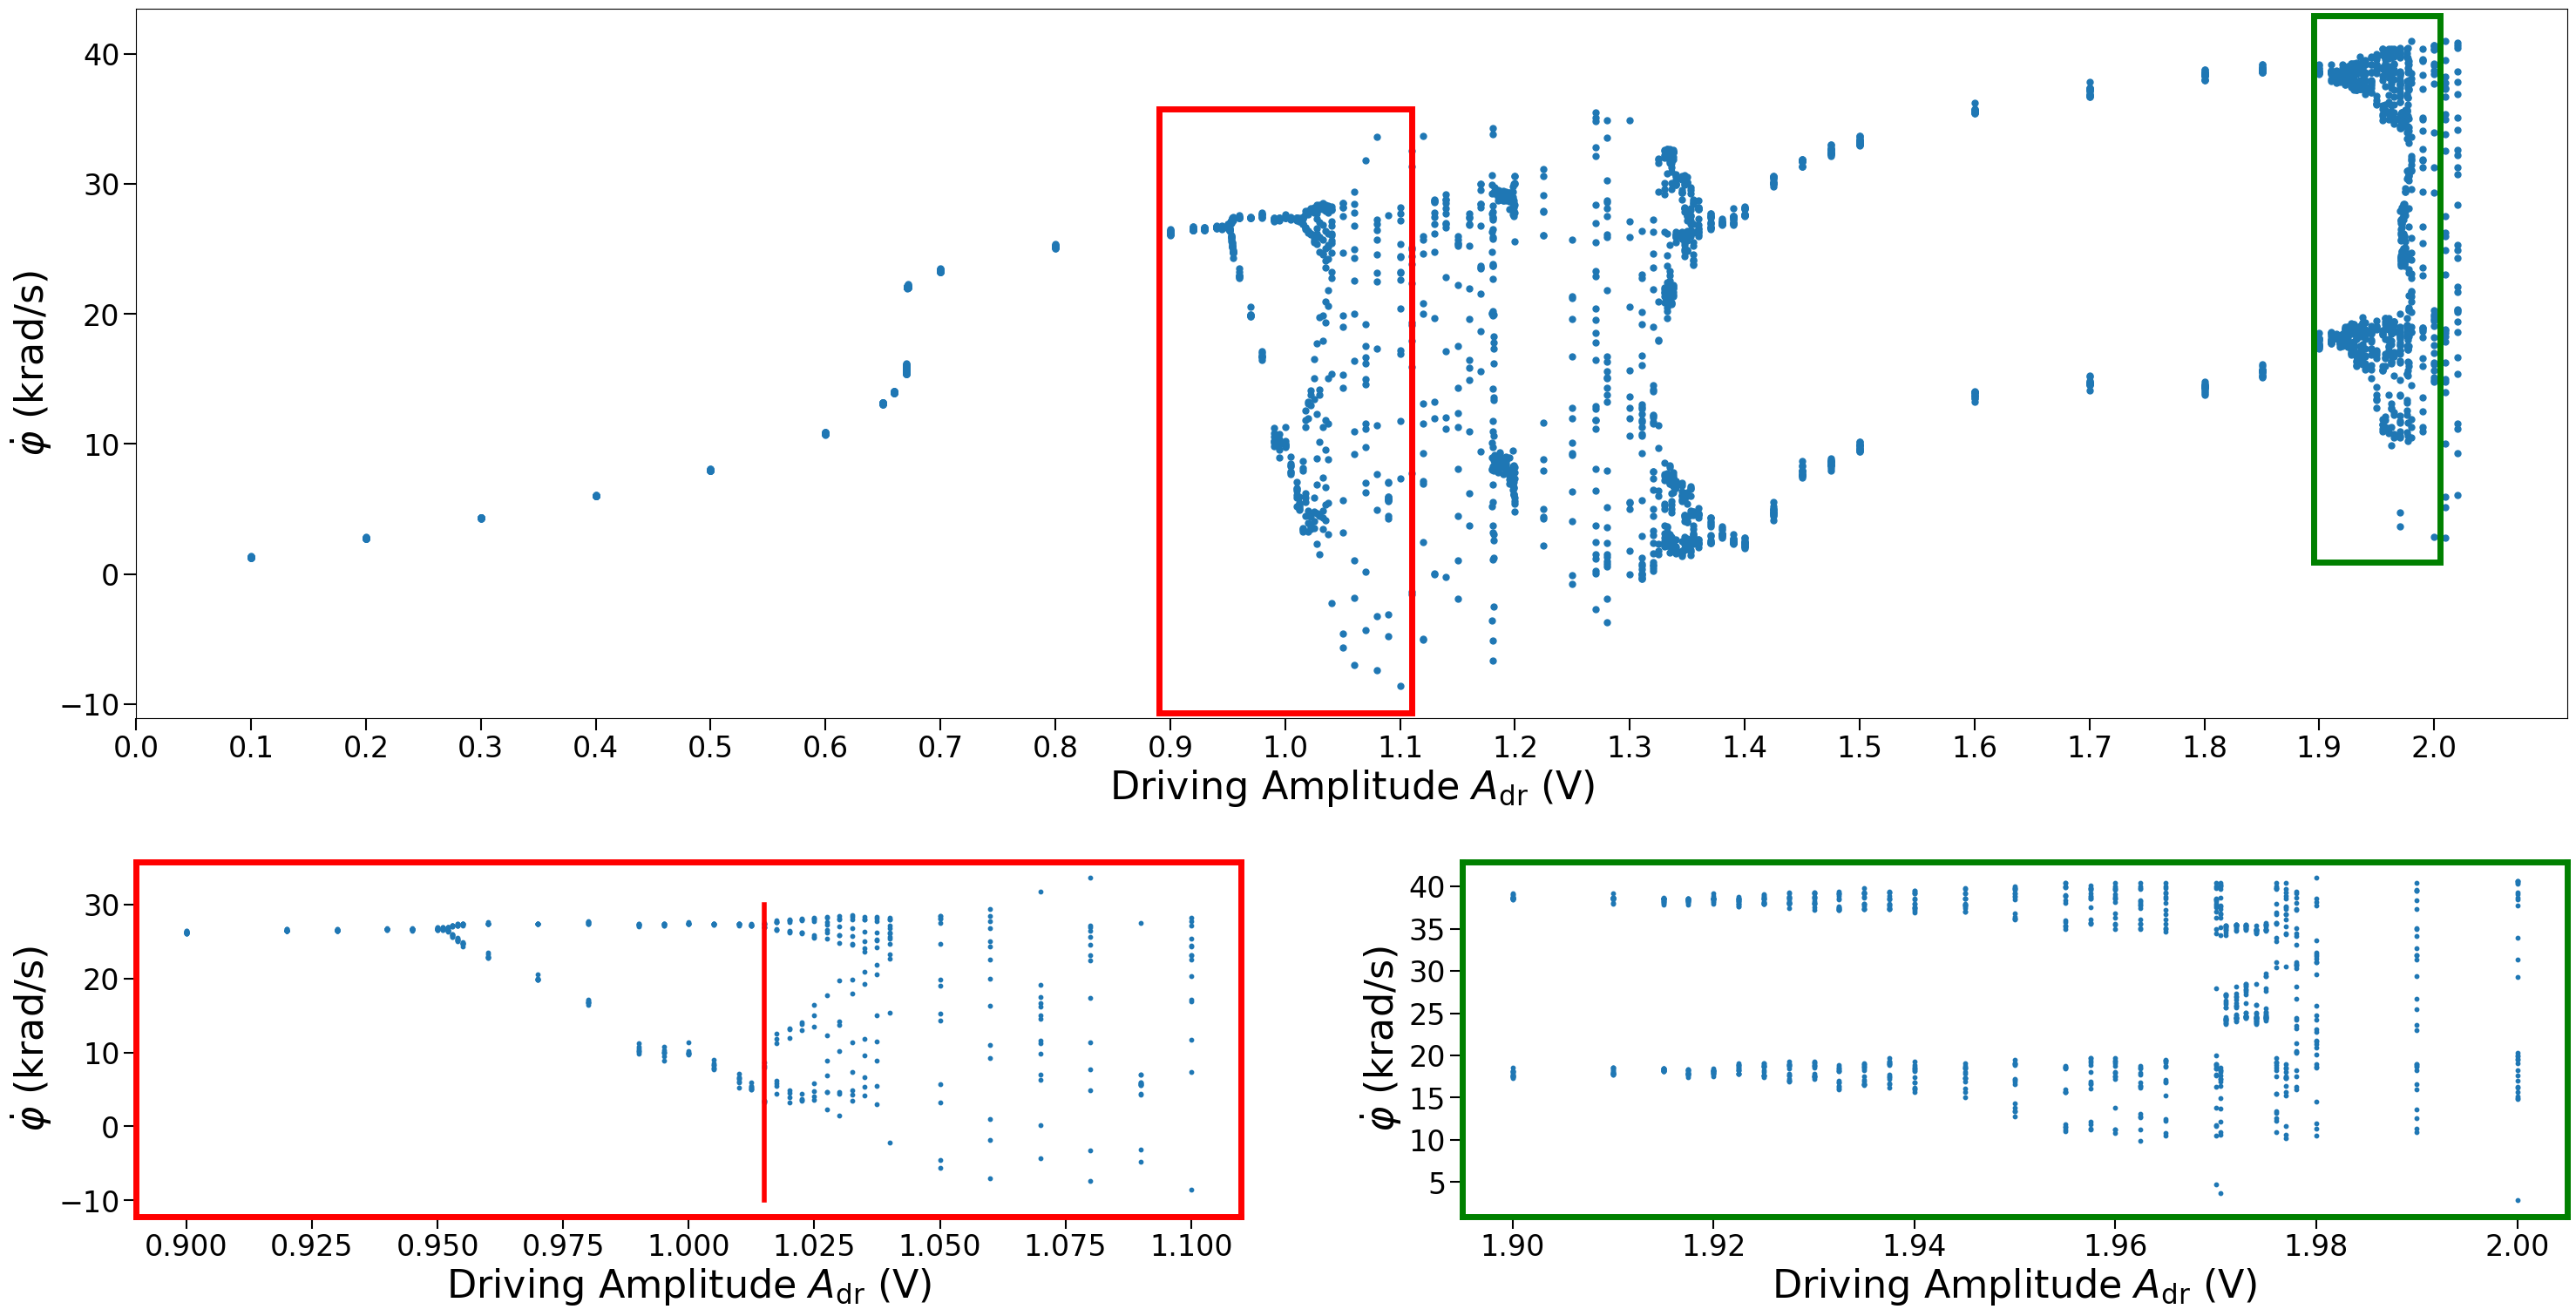

In [128]:
k = 30.64464
omega0 = 143.72222
omegarf = 22.88 * 2 * np.pi

with plt.rc_context(settings):
    # Create 2x2 sub plots
    gs = gridspec.GridSpec(3, 2, height_ratios=[2, 0.005, 1])
    fig = plt.figure(figsize=(36, 18))

    lims = []

    ax1 = fig.add_subplot(gs[0, :]) 

    # plt.figure(figsize=(15, 5))
    ax1.scatter(everything[:,0], omega0 - omegarf - everything[:,1] * k, s=25, marker='o')
    ax1.set_xlabel(r'Driving Amplitude $A_{\mathrm{dr}}$ (V)')
    ax1.set_ylabel(r'$\dot{\varphi}$ (krad/s)');
    ax1.set_xticks(np.arange(0, 2.02, 0.1))

    # SUBPLOT 1

    ax2 = fig.add_subplot(gs[2, 0]) # row 0, col 0
    # ax2.plot([0,1])
    subset = everything[(0.9 <= everything[:,0]) & (everything[:,0] <= 1.1)]
    # subset = everything[(0.95 <= everything[:,0]) & (everything[:,0] <= 0.955)]

    # ax2.figure(figsize=(10, 4))
    ax2.scatter(subset[:,0], 
                omega0 - omegarf - subset[:,1] * k, s=10, marker='o')
    ax2.set_xlabel(r'Driving Amplitude $A_{\mathrm{dr}}$ (V)')
    ax2.set_ylabel(r'$\dot{\varphi}$ (krad/s)');
    lims.append(plt.gca().get_xlim() + plt.gca().get_ylim())
    for spine in ax2.spines.values():
        spine.set_edgecolor('red')
    [x.set_linewidth(5) for x in ax2.spines.values()]
    ax2.plot([flat_volts[36]]*2, [-10, 30], c='red')

    # SUBPLOT 2

    ax3 = fig.add_subplot(gs[2, 1]) # row 0, col 1
    # ax3.plot([0,1])
    subset = everything[(1.9 <= everything[:,0]) & (everything[:,0] <= 2.0)]

    # plt.figure(figsize=(10, 4))
    ax3.scatter(subset[:,0], 
                omega0 - omegarf - subset[:,1] * k, s=10, marker='o')
    ax3.set_xlabel(r'Driving Amplitude $A_{\mathrm{dr}}$ (V)')
    ax3.set_ylabel(r'$\dot{\varphi}$ (krad/s)');
    lims.append(plt.gca().get_xlim() + plt.gca().get_ylim())
    for spine in ax3.spines.values():
        spine.set_edgecolor('green')
    [x.set_linewidth(5) for x in ax3.spines.values()]

    for lim, c in zip(lims, ['r', 'g', 'orange', 'purple']):
        x0, x1, y0, y1 = lim
        ax1.add_patch(patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=5, edgecolor=c, facecolor='none'))
        
    plt.savefig('bifurc', dpi=200, bbox_inches='tight')

In [125]:
len(everything[:,0])

2906

# Fourier Plot

In [30]:
flat_volts = run1 + run2 + run3 + run4 + run5 + run6
flat_dfs = [df for row in dfs for df in row]
flat_interps = [f for row in interps for f in row]

In [31]:
# indices = [20, 21, 22, 23, 25, 26, 27]
indices = [a for a in range(20, 53)]
res = 1000
freq_cap = 3000
N = 10000
Xs = []
Ys = []
Zs = []

for n, (V, df, f) in enumerate(zip([flat_volts[a] for a in indices], 
                                   [flat_dfs[a] for a in indices], 
                                   [flat_interps[a] for a in indices])):
    dt = df['t'].iloc[-1] - df['t'].iloc[0]
    X = scipy.fft.fftfreq(N, dt/N)
    Z = np.abs(scipy.fft.fft(f(np.linspace(df['t'].iloc[0], df['t'].iloc[-1], N))))
    Zs.extend(Z[(0 < X) & (X < freq_cap)])
    Ys.extend([V] * np.sum((0 < X) & (X < freq_cap)))
    Xs.extend(X[(0 < X) & (X < freq_cap)])
    
ext = [np.amin(Xs), np.amax(Xs), np.amin(Ys), np.amax(Ys)]
fft_interp = scipy.interpolate.griddata(
    [[x, y] for x, y in zip(Xs, Ys)], 
    np.log10(Zs),
    [[[x,y] for x in np.linspace(ext[0], ext[1], res)] for y in np.linspace(ext[2], ext[3], res)],
    method='cubic')

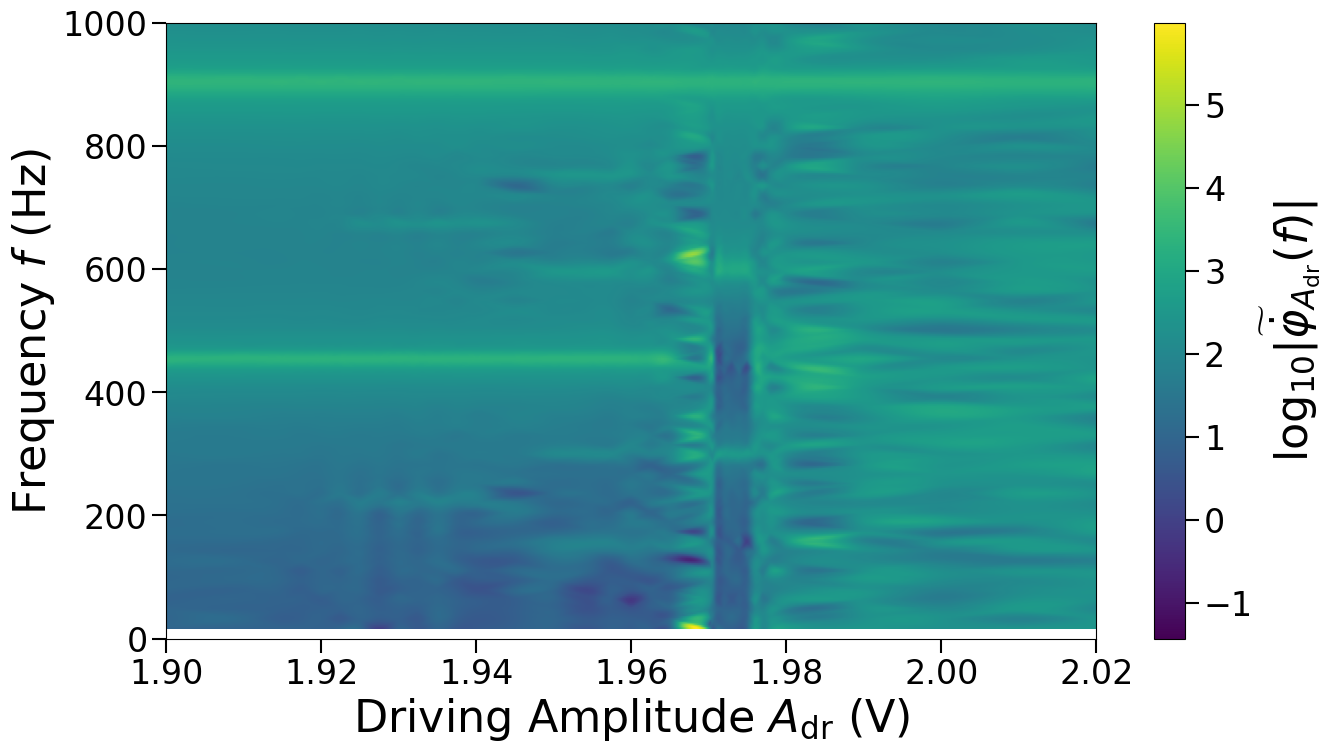

In [162]:
plt.figure(figsize=(15, 8))

with plt.rc_context(settings):
    plt.imshow(fft_interp.T, origin='lower', aspect='auto', extent=[ext[2], ext[3], ext[0], ext[1]])
    cbar = plt.colorbar()
    # plt.yticks([900/(n+1) for n in range(5)]);
    plt.ylim(0, 1000)
    plt.xlabel(r'Driving Amplitude $A_{\mathrm{dr}}$ (V)')
    plt.ylabel(r'Frequency $f$ (Hz)')
    cbar.set_label(r'$\log_{10}|\widetilde{\dot{\varphi}}_{A_{\mathrm{dr}}}(f)|$')
    
    plt.savefig('fourier', dpi=200, bbox_inches='tight')

In [123]:
# indices = [20, 21, 22, 23, 25, 26, 27]
indices = [a for a in range(105, 140)]
res = 1000
freq_cap = 3000
N = 10000
Xs = []
Ys = []
Zs = []

for n, (V, df, f) in enumerate(zip([flat_volts[a] for a in indices], 
                                   [flat_dfs[a] for a in indices], 
                                   [flat_interps[a] for a in indices])):
    dt = df['t'].iloc[-1] - df['t'].iloc[0]
    X = scipy.fft.fftfreq(N, dt/N)
    Z = np.abs(scipy.fft.fft(f(np.linspace(df['t'].iloc[0], df['t'].iloc[-1], N))))
    Zs.extend(Z[(0 < X) & (X < freq_cap)])
    Ys.extend([V] * np.sum((0 < X) & (X < freq_cap)))
    Xs.extend(X[(0 < X) & (X < freq_cap)])
    
ext = [np.amin(Xs), np.amax(Xs), np.amin(Ys), np.amax(Ys)]
fft_interp = scipy.interpolate.griddata(
    [[x, y] for x, y in zip(Xs, Ys)], 
    np.log10(Zs),
    [[[x,y] for x in np.linspace(ext[0], ext[1], res)] for y in np.linspace(ext[2], ext[3], res)],
    method='cubic')

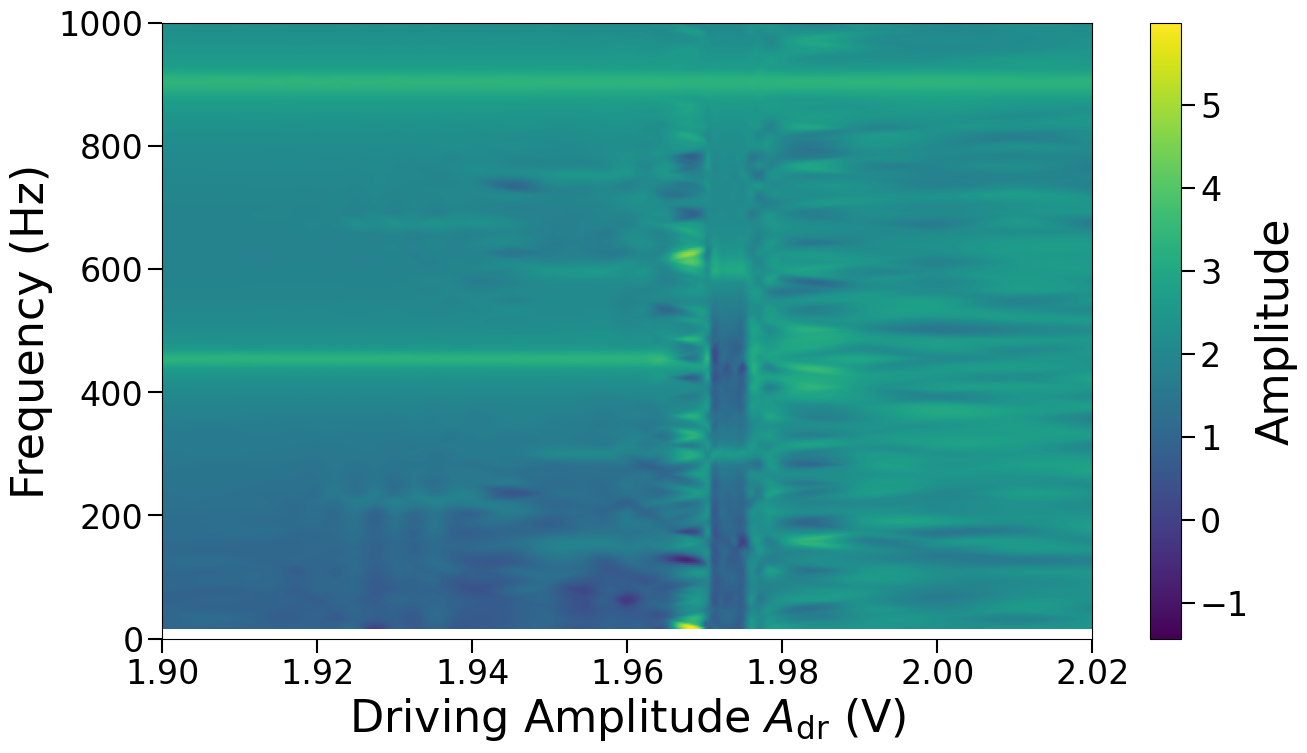

In [124]:
plt.figure(figsize=(15, 8))

with plt.rc_context(settings):
    plt.imshow(fft_interp.T, origin='lower', aspect='auto', extent=[ext[2], ext[3], ext[0], ext[1]])
    cbar = plt.colorbar()
    # plt.yticks([900/(n+1) for n in range(5)]);
    plt.ylim(0, 1000)
    plt.xlabel(r'Driving Amplitude $A_{\mathrm{dr}}$ (V)')
    plt.ylabel(r'Frequency (Hz)')
    cbar.set_label('Amplitude')
    
    # plt.savefig('fourier', dpi=200, bbox_inches='tight')

# Critical Exponent

In [92]:
Vs_crit = []
fourier_coef = []
a, b = 22, 36

for V, df, f in zip(flat_volts[a:b], flat_dfs[a:b], flat_interps[a:b]):
    dt = (df['t'].iloc[-1] - df['t'].iloc[0]) / N
    fft_f = scipy.interpolate.interp1d(
        scipy.fft.fftfreq(N, (df['t'].iloc[-1] - df['t'].iloc[0])/N),
        np.log10(np.abs(scipy.fft.fft(f(np.linspace(df['t'].iloc[0], df['t'].iloc[-1], N)), norm='forward'))))
    Vs_crit.append(V)
    fourier_coef.append(fft_f(450))

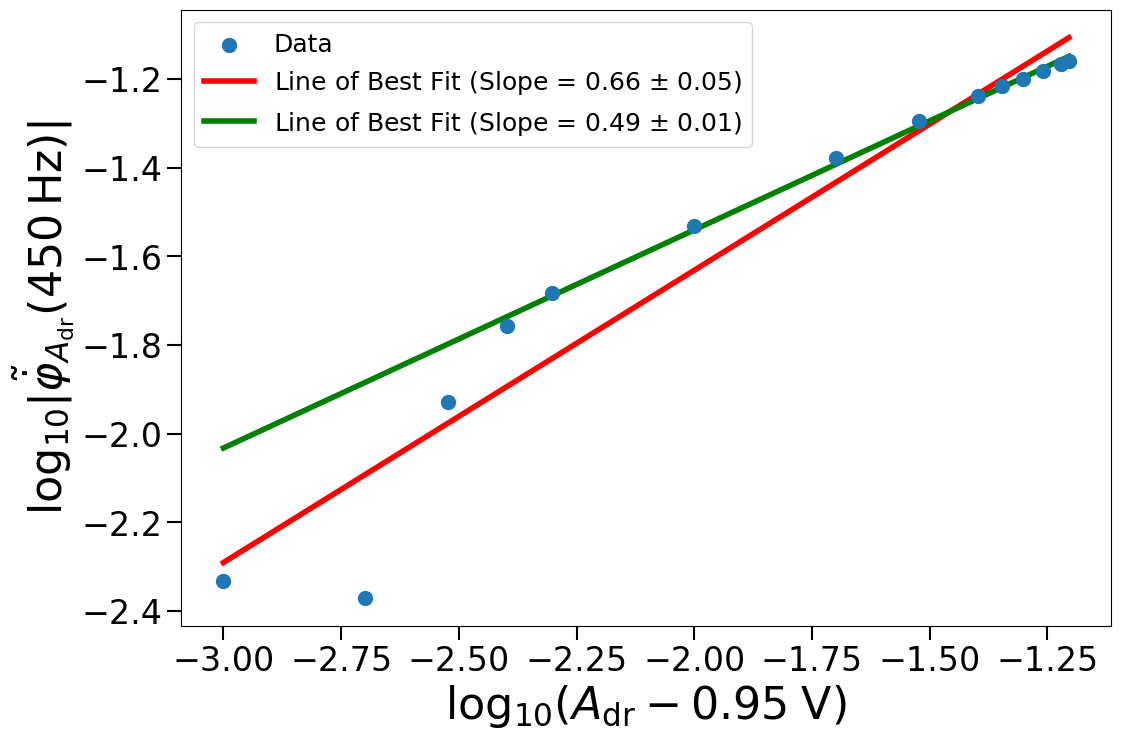

In [157]:
X = np.log10(np.array(Vs_crit) - 0.95)
Y = fourier_coef

result1 = scipy.stats.linregress(X, Y)
result2 = scipy.stats.linregress(X[3:], Y[3:])

m1 = result1.slope
b1 = result1.intercept
r1 = result1.rvalue
slope_err1 = result1.stderr
yint_err1 = result1.intercept_stderr

m2 = result2.slope
b2 = result2.intercept
r2 = result2.rvalue
slope_err2 = result2.stderr
yint_err2 = result2.intercept_stderr

with plt.rc_context(settings):
    plt.figure(figsize=(12, 8))
    plt.scatter(X, Y, label='Data')
    plt.xlabel(r'$\log_{10}(A_{\mathrm{dr}} - 0.95 \; \mathrm{V})$')
    plt.ylabel(r'$\log_{10}|\tilde{\dot{\varphi}}_{A_{\mathrm{dr}}}(450 \, \mathrm{Hz})|$')
    plt.plot(X, m1 * X + b1, c='r', label=f'Line of Best Fit (Slope = {m1:0.2f} $\pm$ {slope_err1:0.2f})', zorder=-100)
    plt.plot(X, m2 * X + b2, c='g', label=f'Line of Best Fit (Slope = {m2:0.2f} $\pm$ {slope_err2:0.2f})', zorder=-100)
    plt.legend()
    
    plt.savefig('crit_exp', dpi=200, bbox_inches='tight')

# Phase Space Diagrams

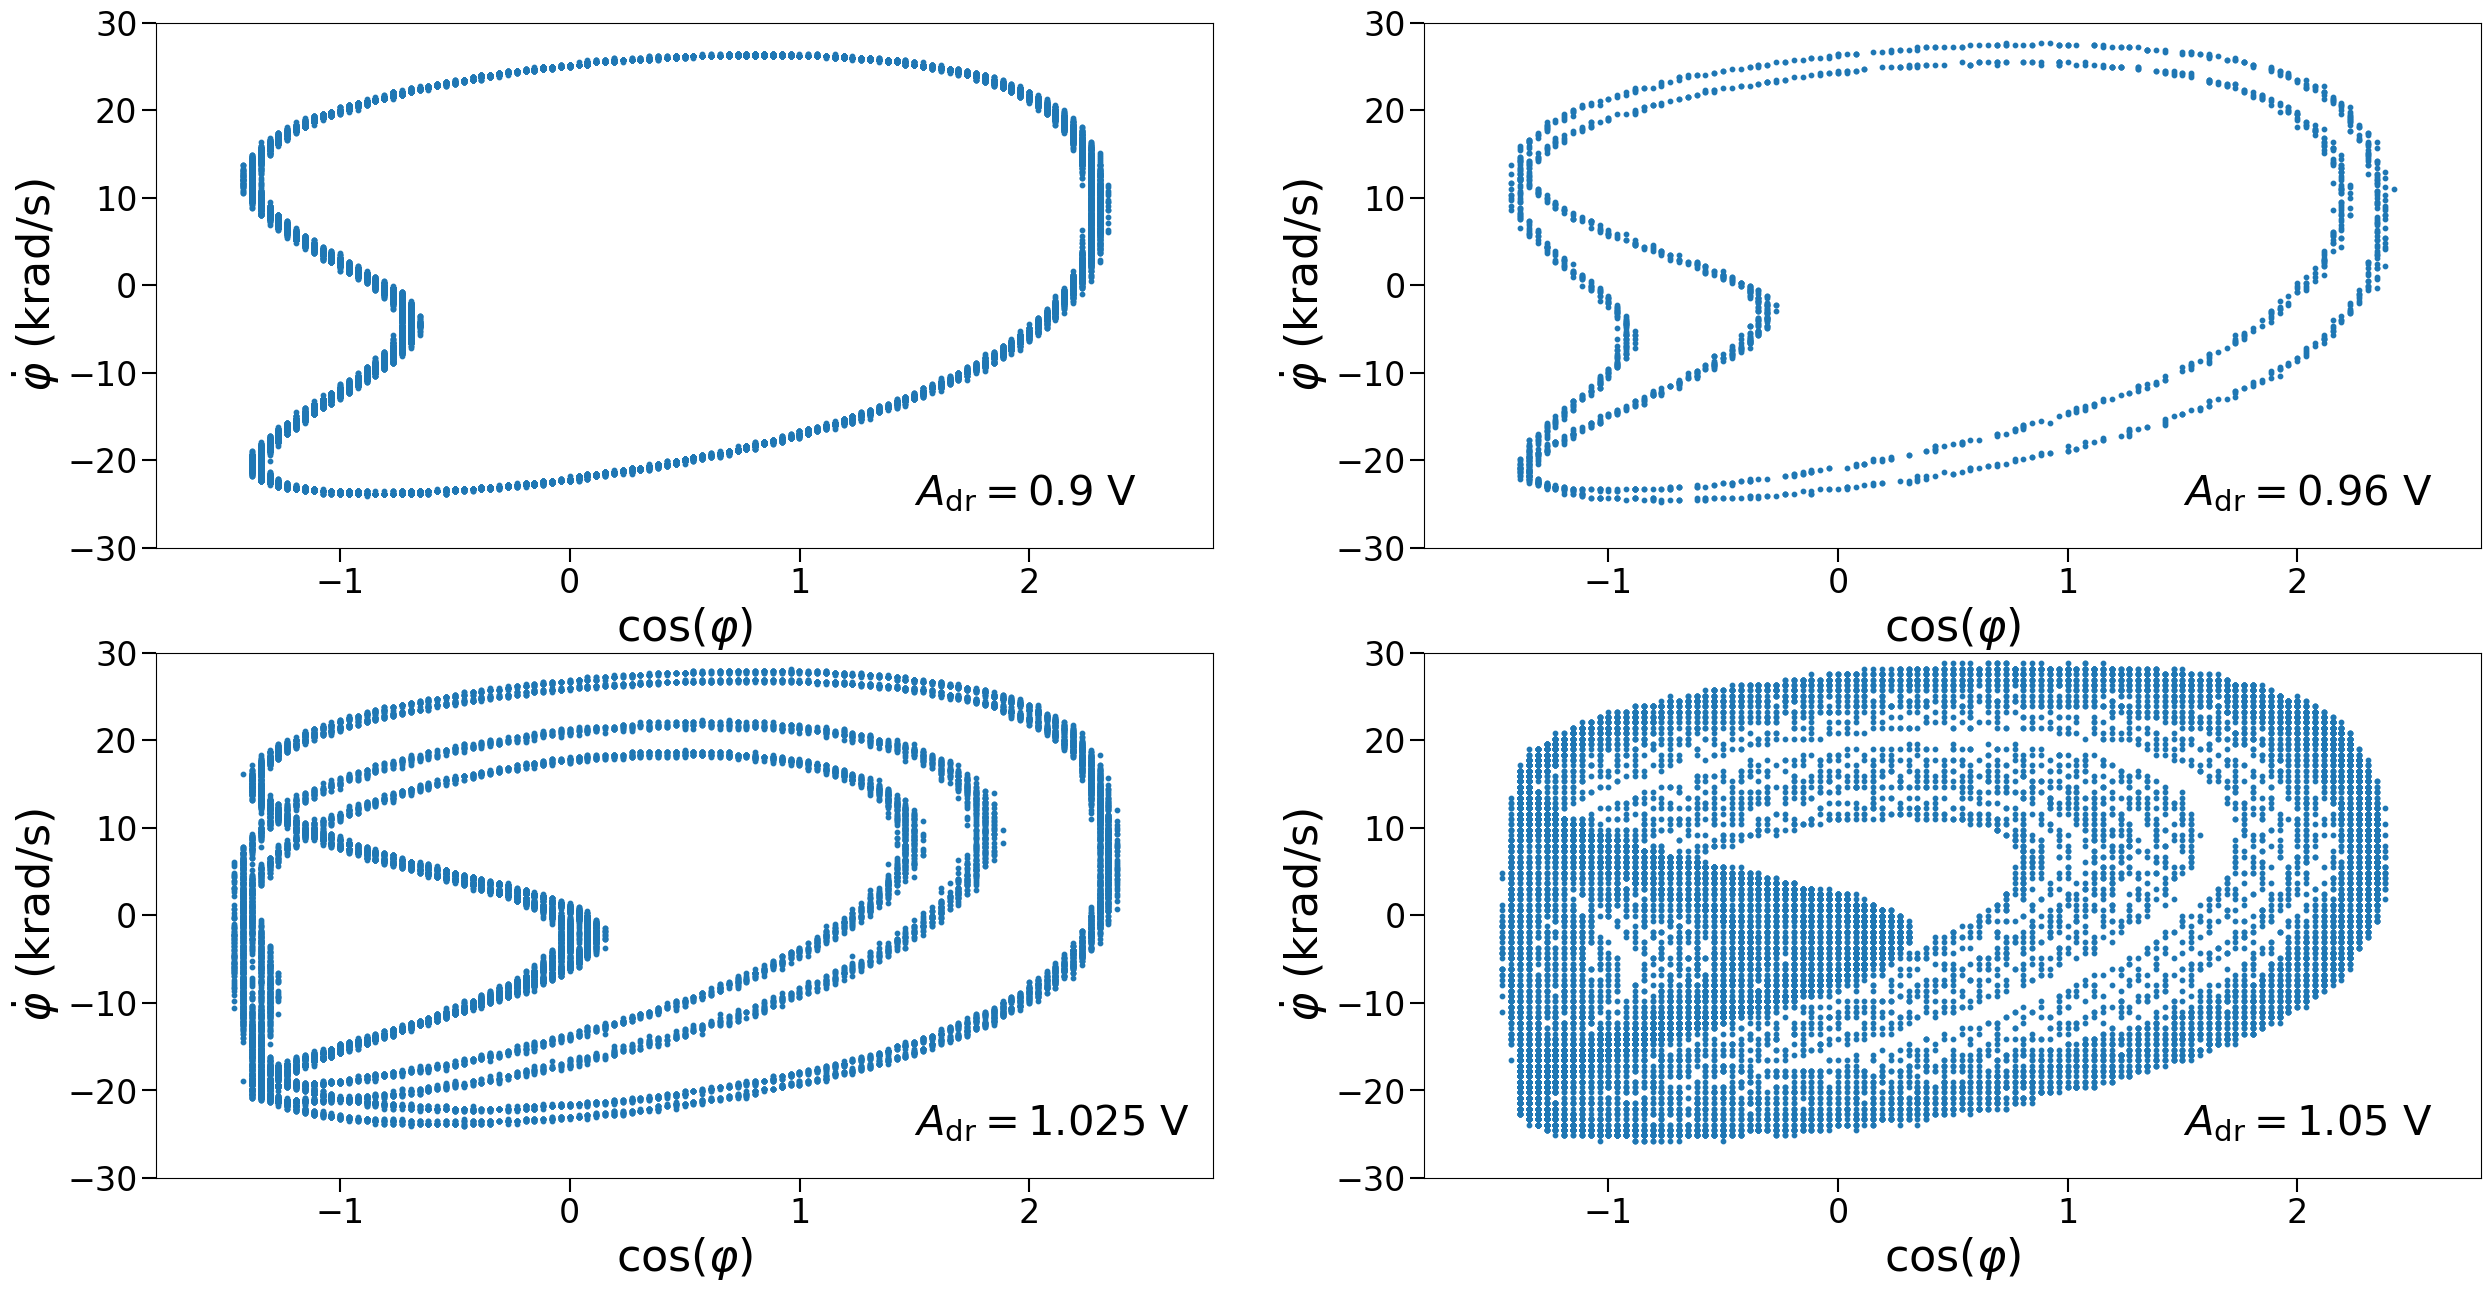

In [106]:
csvs = csvs = sorted(['./phase_space_data/' + f for f in os.listdir('./phase_space_data/') if f.endswith('.CSV')])
dfs_traces = [read_osc_csv(f) for f in csvs]
Vs = [0.9, 0.96, 1.025, 1.05]

k = 30.64464
omega0 = 143.72222
omegarf = 22.88 * 2 * np.pi
Arf = 1.72/2

with plt.rc_context(settings):
    fig, axs = plt.subplots(2, 2, figsize=(30,15))

    for a, row in enumerate(axs):
        for b, ax in enumerate(row):
            ax.scatter(dfs_traces[2 * a + b]['x'] / (1.21 * Arf), omega0 - omegarf - k * dfs_traces[2 * a + b]['y'], s=10)
            ax.set_xlabel(r'$\cos(\varphi)$')
            ax.set_ylabel(r'$\dot{\varphi}$ (krad/s)')
            ax.text(1.5, -25, '$A_{\mathrm{dr}} = ' + str(Vs[2*a + b]) + '$ V')
            ax.set_xlim(-1.8, 2.8)
            ax.set_ylim(-30, 30)
            
    plt.savefig('phase_space', dpi=200, bbox_inches='tight')

In [131]:
print([len(df) for df in dfs_traces])

[20000, 2000, 20000, 20000]
